<a href="https://colab.research.google.com/github/jwoonge/ML-algorithms/blob/master/10_Text_Classification_using_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

20141261 송제웅  
# 10 Text Classification using Neural Networks  

## - function definition  
[0] import libraries

In [ ]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import cupy as cp
from google.colab import drive

drive.mount('/content/gdrive')

[1] read datas

In [ ]:
def read_data(filepath, num_feature, min_df=0.7, max_df=5.0):
    review_data = load_files(filepath)
    X, y = review_data.data, review_data.target

    documents = []

    stemmer = WordNetLemmatizer()

    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        # Converting to Lowercase
        document = document.lower()
        # Lemmatization
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        
        documents.append(document)

    vectorizer = CountVectorizer(max_features=num_feature, min_df=min_df, max_df=max_df, stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(documents).toarray()

    tfidfconverter = TfidfTransformer()
    X = tfidfconverter.fit_transform(X).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_trian = cp.array(X_train) ; X_test = cp.array(X_test)
    y_train = cp.array(y_train) ; y_test = cp.array(y_test)
    y_train = cp.reshape(y_train,[len(y_train),1])
    y_test = cp.reshape(y_test, [len(y_test),1])
    return X_train, y_train, X_test, y_test


[2] Activate Function : Sigmoid  
$\sigma(z) = \frac{1}{1+exp(-z)}$  

[3] derivatived Sigmoid  
$\sigma'(z) = \sigma(z)(1-\sigma(z))$ 

In [6]:
def sigmoid(input):
    return 1/(1+cp.exp(-input))
def sigmoid_d(input):
    return sigmoid(input)*(1-sigmoid(input))

[4] Object function  
$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=0}^9 (-l_k^{(i)} log(h_k^{(i)}) - (1-l_k^{(i)}) log(1-h_k^{(i)})) + \frac{\lambda}{2n} \sum_{j=1}^n \theta_j^2$

In [7]:
def loss(h, label, weights, lam):
    pre = cp.sum(cp.average(-label * cp.log(h) - (1-label)*cp.log(1-h), axis=0))
    n = 0
    theta_sum = 0

    for weight in weights:
        n += weight.size
        theta_sum += cp.sum(cp.square(weight))
    reg = lam/(2*n)*theta_sum

    return pre + reg

## - Class definition  

[0] constructor  
random initial condition for weights with mean 0, and standard derivation 1    
[1] calculate values by forward pass  
   return [$x\ y\_ \ y\  ... h\_ \ h$]    
[2] gradient descent by backward pass  
$\theta_k^{(t+1)} := \theta_k^{(t)} - \alpha \frac{\delta J(\theta^{(t)})}{\delta \theta_k} $

gradient for $w = \frac{\delta J}{\delta w}
= (\frac{\delta J}{\delta h}*\frac{\delta h}{\delta h\_})*\frac{\delta h\_}{\delta w}$  
$=(\frac{1-l}{1-h}-\frac{l}{h})(\sigma'(h\_))*z$  

gradient for $v = \frac{\delta J}{\delta v}
= (\frac{\delta J}{\delta h}*\frac{\delta h}{\delta h\_})*(\frac{\delta h\_}{\delta z}*\frac{\delta z}{\delta z\_})*\frac{\delta z\_}{\delta v}$  
$=(\frac{1-l}{1-h}-\frac{l}{h})(\sigma'(h\_))*(w*(\sigma'(z\_)))*y$  

gradient for $u = \frac{\delta J}{\delta u}
= (\frac{\delta J}{\delta h}*\frac{\delta h}{\delta h\_})*(\frac{\delta h\_}{\delta z}*\frac{\delta z}{\delta z\_})*(\frac{\delta z\_}{\delta y}*\frac{\delta y}{\delta y\_})*\frac{\delta y\_}{\delta u}$  
$=(\frac{1-l}{1-h}-\frac{l}{h})(\sigma'(h\_))*(w*(\sigma'(z\_)))*(v*(\sigma'(y\_)))*x$    
$\theta^{(t+1)} = \theta^{t} - \alpha((gradient)/m + \lambda\theta^{(t)}/n)$    
[3] optimize as repeating gradient descnet    
[4] predict class by forwarding using calculated weights  

In [8]:
class classifier:
    def __init__(self, shape, lam, learning_rate):
        self.weights = []
        for i in range(len(shape)-1):
            self.weights.append(cp.random.randn(shape[i]+1, shape[i+1]))
        self.learning_rate = learning_rate
        self.lam = lam
        self.num_layer = len(self.weights)
        self.n = 0
        for weight in self.weights:
            self.n += weight.size
    
    def forward_pass(self, input, weights=[]):
        if weights==[]:
            weights = self.weights
        values = []
        values.append(cp.array(np.insert(cp.asnumpy(input), 0, 1, axis=1)))
        values.append(cp.dot(values[-1], weights[0]))
        values.append(cp.array(np.insert(cp.asnumpy(sigmoid(values[-1])),0,1,axis=1)))
        for i in range(1, len(weights)-1):
            values.append(cp.dot(values[-1], weights[i]))
            values.append(cp.array(np.insert(cp.asnumpy(sigmoid(values[-1])),0,1,axis=1)))
        values.append(cp.dot(values[-1], weights[-1]))
        values.append(sigmoid(values[-1]))
        
        return values

    def gradient_descent(self, forward_values, label):
        update_values = []
        m = len(label)
        mult = (sigmoid_d(forward_values[-2]) * ((1-label)/(1-forward_values[-1]) - label/forward_values[-1])).T
        layer = len(self.weights)-1
        update_values.append(cp.dot(mult, forward_values[2*layer]).T)
        
        for i in range(1, len(self.weights)):
            layer = len(self.weights) - i - 1
            mult = (cp.dot(mult.T, self.weights[layer+1][1:,:].T) * (sigmoid_d(forward_values[layer*2+1]))).T
            update_values.append(cp.dot(mult, forward_values[2*layer]).T)
        for i in range(len(self.weights)):
            layer = len(self.weights)-i-1
            self.weights[layer] = self.weights[layer] - self.learning_rate * (update_values[i]/m + self.lam*self.weights[layer]/self.n)

    def optimize(self, data_train, label_train, data_test, label_test, epoch):
        forward_train = self.forward_pass(data_train)
        forward_test = self.forward_pass(data_test)
        h_train = forward_train[-1]
        h_test = forward_test[-1]
        y_pred_train = np.where(cp.asnumpy(h_train)<0.5, 0, 1)
        y_pred_test = np.where(cp.asnumpy(h_test)<0.5, 0, 1)
        label_train_np = cp.asnumpy(label_train)
        label_test_np = cp.asnumpy(label_test)
        
        self.loss_train = [loss(h_train, label_train, self.weights, self.lam)]
        self.loss_test = [loss(h_test, label_test, self.weights, self.lam)]
        self.accuracy_train = [accuracy_score(label_train_np, y_pred_train)*100]
        self.accuracy_test = [accuracy_score(label_test_np, y_pred_test)*100]
        self.report_train = [classification_report(label_train_np, y_pred_train)]
        self.report_test = [classification_report(label_test_np, y_pred_test)]
        self.confusion_matrix_train = [confusion_matrix(label_train_np, y_pred_train)]
        self.confusion_matrix_test = [confusion_matrix(label_test_np, y_pred_test)]
        
        for i in range(epoch-1):

            self.gradient_descent(forward_train, label_train)
            forward_train = self.forward_pass(data_train)
            forward_test = self.forward_pass(data_test)
            h_train = forward_train[-1]
            h_test = forward_test[-1]
            y_pred_train = np.where(cp.asnumpy(h_train)<0.5, 0, 1)
            y_pred_test = np.where(cp.asnumpy(h_test)<0.5, 0, 1)

            self.loss_train.append(loss(h_train, label_train, self.weights, self.lam))
            self.loss_test.append(loss(h_test, label_test, self.weights, self.lam))
            self.accuracy_train.append(accuracy_score(label_train_np, y_pred_train)*100)
            self.accuracy_test.append(accuracy_score(label_test_np, y_pred_test)*100)
            self.report_train.append(classification_report(label_train_np, y_pred_train))
            self.report_test.append(classification_report(label_test_np, y_pred_test))
            self.confusion_matrix_train.append(confusion_matrix(label_train_np, y_pred_train))
            self.confusion_matrix_test.append(confusion_matrix(label_test_np, y_pred_test))


            print(i," LOS_T:", format(float(self.loss_train[-1]),'.5f'), "\tACC_T:", format(float(self.accuracy_train[-1]),'.5f'), "| LOS_V:", format(float(self.loss_test[-1]),'.5f'), "ACC_V:" ,format(float(self.accuracy_test[-1]),'.5f'), format(self.lam/self.n,'.10f'), self.n)

## - Main  
read data files and vectorize documents with  
selecting features by  
num_feature : 3000  
max doc freq : 6  
min doc freq : 0.8  

In [10]:
data_train, label_train, data_test, label_test = read_data(r'movie_review', 3000, 6, 0.8)

create classifier object and call optimize  
input unit : 3000 (+ a bias)  
output unit : 1  
hidden : 20 (+ a bias)  
$\lambda$ : 12  
$\alpha$ : 0.6  

In [ ]:
Classifier = classifier([3000, 20, 1], lam=12, learning_rate=0.6)
Classifier.optimize(data_train, label_train, data_test, label_test, 30000)

## - Results
[1] Plot the Loss Curve

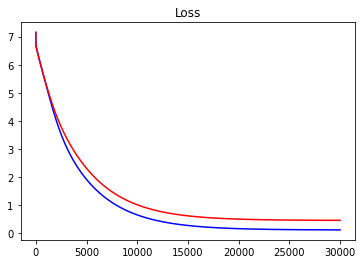

In [13]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(Classifier.loss_train, c='b')
plt.plot(Classifier.loss_test, c='r')
plt.show()

[2] Plot the Accuracy Curve

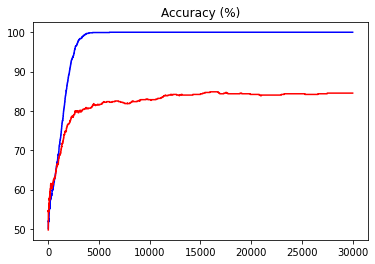

In [14]:
plt.title('Accuracy (%)')
plt.plot(Classifier.accuracy_train, c='b')
plt.plot(Classifier.accuracy_test, c='r')
plt.show()

[3] Plot the Quantitative Results

In [15]:
print('for training datas...')
print('confusion matrix : ')
print(Classifier.confusion_matrix_train[-1])
print('\nclassification report : ')
print(Classifier.report_train[-1])
print('final accuracy : ',Classifier.accuracy_train[-1],'%')

for training datas...
confusion matrix : 
[[699   0]
 [  0 702]]

classification report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401

final accuracy :  100.0 %


In [16]:
print('for testing datas...')
print('confusion matrix : ')
print(Classifier.confusion_matrix_test[-1])
print('\nclassification report : ')
print(Classifier.report_test[-1])
print('final accuracy : ',Classifier.accuracy_test[-1],'%')

for testing datas...
confusion matrix : 
[[251  51]
 [ 42 257]]

classification report : 
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       302
           1       0.83      0.86      0.85       299

    accuracy                           0.85       601
   macro avg       0.85      0.85      0.85       601
weighted avg       0.85      0.85      0.85       601

final accuracy :  84.52579034941763 %
